### Universidad de Granada | ETSIIT


---
# **Práctica 3**: Redes Neuronales Convolucionales
---
**Asignatura:** Visión por Computador

**Autor:** Lugli, Valentino Glauco · YB0819879

## **Preámbulo**
### Añadiendo las librerías y funciones en común de los ejercicios necesarias para realizar la práctica.

In [ ]:
# LIBRERÍAS

#   Usando Matplotlib para mostrar imágenes
import matplotlib.pyplot as plt
import matplotlib.colors as clr

#   Usando OpenCV para el resto de cosas con imágenes
import cv2 as cv

#   Usando Numpy para cálculos matriciales
import numpy as np

#   Usando Math para funciones matemáticas avanzadas
import math

#   Usando Random para obtener puntos
import random

#   Usando keras y tensorflow para las redes
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.utils as np_utils
from keras.models import Sequential

# Importar el conjunto de datos
from keras.datasets import cifar100

# Importando nombres de las capas por legibilidad
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, UpSampling2D

# Cosas para ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Imports para hacer el conjunto de validación
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.preprocessing.image import load_img,img_to_array

# Importando el recolector de basura
import gc

#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist):

  #plt.figure(figsize=(4,3), dpi= 200)
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  #plt.figure(figsize=(4,3), dpi= 200)
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  imagenes.astype(np.float32)
  return imagenes, clases


#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path):
  # Cargamos los ficheros
  train_images = np.loadtxt(path + "/train.txt", dtype = str)
  test_images = np.loadtxt(path + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images, path)
  test, test_clases = leerImagenes(test_images, path)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]
  
  return train, train_clases, test, test_clases

# Callback nuevo para llamar al recolector de basura al final de cada época.
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


def getDataIterators(train_x, train_y, test_x, batches):
    """
      Generador de iteradores dados los datos de entrada, 
      no realiza aumento de datos pero se utiliza para
      poder utilizar la misma función que utiliza el fit.   

    Parameters
    ----------
    train_x : Lista de imagenes de entrenamiento
    train_y : Lista de etiquetas de entrenamiento
    test_x : Lista de imágenes de prueba
    batches: Numero de batches de entrenamiento.

    Returns
    -------
    it_train: Iterador de imágenes de entrenamiento.
    it_validation: Iterador de imágenes de validación.
    test_x: Imágenes de test ajustadas a los parámetros de entrenamiento.

    """  

    # Obtener iterador de IDG
    dataG = ImageDataGenerator()
    
    # Hacer el fit a los datos de entrenamiento.
    dataG.fit(train_x)
    
    # Realizar la división entre entrenamiento y validación con la función.
    X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.1, stratify=train_y)
    
    # Obtener el iterador de entrenamiento.
    it_train = dataG.flow(X_train , Y_train, batch_size = batches)

    # Obtener el iterador de validación.
    it_validation = dataG.flow(X_val , Y_val)

    # Obtener el iterador de test.
    dataT = ImageDataGenerator()
    
    # Hacer fit con los datos de entrenamiento
    dataT.fit(train_x)

    # Estandarizar los datos de test con los de entrenamiento.
    dataT.standardize(test_x)

    return it_train, it_validation, test_x



def getAugDataIterators(train_x, train_y, test_x, batches):
    """
      Generador de iteradores dados los datos de entrada, 
      con aumento de datos.

    Parameters
    ----------
    train_x : Lista de imagenes de entrenamiento
    train_y : Lista de etiquetas de entrenamiento
    test_x : Lista de imágenes de prueba
    batches: Numero de batches de entrenamiento.

    Returns
    -------
    it_train: Iterador de imágenes de entrenamiento.
    it_validation: Iterador de imágenes de validación.
    test_x: Imágenes de test ajustadas a los parámetros de entrenamiento.

    """  

    # Aumento de datos, se añade: 
    # -Rotación hasta 10º
    # -Cambios de posición vertical y horizontal
    # -Voltear la imagen horizontalmente.
    dataG = ImageDataGenerator(rotation_range=10, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2,
                               horizontal_flip=True)
    
    # Hacer el fit a los datos de entrenamiento.
    dataG.fit(train_x)
    
    # Realizar la división entre entrenamiento y validación con la función.
    X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.1, stratify=train_y)

    # Obtener el iterador de entrenamiento.
    it_train = dataG.flow(X_train , Y_train, batch_size = batches)

    # Obtener el iterador de validación.
    it_validation = dataG.flow(X_val , Y_val)

    # Obtener el iterador de test.
    dataT = ImageDataGenerator()
    
    # Hacer fit con los datos de entrenamiento
    dataT.fit(train_x)

    # Estandarizar los datos de test con los de entrenamiento.
    dataT.standardize(test_x)

    return it_train, it_validation, test_x

def compileModel(model):
    """
      Compilar un modelo dado unos parámetros por defecto.

    Parameters
    ----------
    model: Red neuronal

    Returns
    -------
    None

    """      
    # Compilando el modelo con función de pérdida de entropía cruzada categórica
    # con el optimizador Adam en parámetros por defecto y con la métrica de 
    # precisión a los datos.
    model.compile(loss = k.losses.categorical_crossentropy,
              optimizer = 'adam',
              metrics = ['accuracy'])


def trainModel(model, train_x, val_x, batchSize, trainEpochs):
    """
    Entrenar una red convolucional

    Parameters
    ----------
    model: Modelo de Keras
      Modelo que se desea entrenar.

    train_x: Iterador de los datos de entrenamiento.
    
    val_x: Iterador de los datos de validación.

    batchSize: Tamaño del batch

    trainEpochs: Número de épocas en las que entrenar.

    Returns
    -------
    hist: Objeto que contiene el historial de entrenamiento de la red.

    """  
    # Se crea el callback del recolector de basura
    gcCallBack = GarbageCollectorCallback()

    # Se entrena la red.
    hist = model.fit(train_x, batch_size=batchSize, epochs=trainEpochs, 
                     validation_data = val_x, verbose=1, 
                     callbacks=[gcCallBack])

    return hist

def testModel(model, text_x, test_y, hist):
    """
    Evalúa el modelo en el conjunto de datos de test

    Parameters
    ----------
    model: Modelo de Keras

    test_x: Lista de imágenes de test
    test_y: Lista de etiquetas de test
    hist: Objeto que contiene el historial de entrenamiento

    Returns
    -------
    None

    """  

    # Se muetra la gráfica de entrenamiento y validación.
    mostrarEvolucion(hist)
    print("Evaluando...")
    # Se evalúa e imprimen los datos de pérdida y precisión.
    score = model.evaluate(text_x, test_y, verbose=1)
    print("Resultados de Evaluación en Test\n - Loss:", score[0])
    print(' - Accuracy: ', score[1] * 100,"%")

def getResNet50(p_pooling, inputShape):
    """
      Obtener un modelo de la red ResNet50

    Parameters
    ----------
    p_pooling: String
      Indica que clase de Pooling se desea.

    inputShape: Tupla
      Indica la forma que tendrá la entrada a la red.

    Returns
    -------
    model: Modelo de ResNet

    """  
    # Se obtiene una red ResNet50, con los pesos entrenados a ImageNet, siempre
    # se obvía el clasificador con top = False.
    model = ResNet50(weights = 'imagenet', include_top = False, input_shape = inputShape, pooling = p_pooling)
    return model

def getBirdNetV1(model, onlyFinal):
    """
      Obtener la versión 0 y 1 de BirdNet

    Parameters
    ----------
    model: Modelo de Keras
      Modelo base del cual construir BirdNet

    onlyFinal: Booleano
      Indica si solo se utilizará solo el clasificador nuevo.

    Returns
    -------
    model: Modelo de BirdNet

    """  
  
    # Se hacen que las capas de ResNet no puedan sen entrnadas.
    for layer in model.layers:
      layer.trainable = False

    # Se obtiene la última capa de ResNet para conectar el resto.
    x = model.output

    # Si es BirdNetV1, incluir estas capas:
    if(not onlyFinal):

      x = (Dense(1024, activation="relu")) (x)

      x = (Dropout(0.5)) (x)

      x = (Dense(512, activation='relu')) (x)

    # Añadir el clasificador
    lastLayer = Dense(200, activation='softmax') (x)

    # Generar un modelo nuevo con las capas adicionales e incluyendo a ResNet
    retModel = k.Model(inputs = model.inputs, outputs = lastLayer)

    return retModel

def getBirdNetV2(model):
    """
      Obtener la versión 2 de BirdNet

    Parameters
    ----------
    model: Modelo de Keras
      Modelo base del cual construir BirdNet

    Returns
    -------
    model: Modelo de BirdNet

    """  

    # Ídem con la función anterior
    for layer in model.layers:
      layer.trainable = False

    x = model.output

    x = Conv2D(64, 3, padding='same', activation='relu') (x)

    x = BatchNormalization() (x)

    x = Flatten() (x)

    x = Dense(256, activation='relu') (x)

    lastLayer = Dense(200, activation='softmax') (x)

    retModel = k.Model(inputs = model.inputs, outputs = lastLayer)

    return retModel


def getBirdNetV3(model):
    """
      Obtener la versión 3 de BirdNet

    Parameters
    ----------
    model: Modelo de Keras
      Modelo base del cual construir BirdNet

    onlyFinal: Booleano
      Indica si solo se utilizará solo el clasificador nuevo.

    Returns
    -------
    model: Modelo de BirdNet

    """  

    #Ídem con la versión anterior.
    x = model.output
    
    lastLayer = Dense(200, activation='softmax') (x)

    retModel = k.Model(inputs = model.inputs, outputs = lastLayer)

    return retModel


def getBirdNetV4(model):
    """
      Obtener la versión 0 y 1 de BirdNet

    Parameters
    ----------
    model: Modelo de Keras
      Modelo base del cual construir BirdNet

    onlyFinal: Booleano
      Indica si solo se utilizará solo el clasificador nuevo.

    Returns
    -------
    model: Modelo de BirdNet

    """  

    # Ídem con la versión anterior, pero ahora no se colocan directamente los
    # pesos a no entrenables.
    x = model.output
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    lastLayer = Dense(200, activation="softmax")(x)

    retModel = k.Model(inputs = base.inputs, outputs = lastLayer)

    return retModel

---
##**Ejercicio 3** 

### Carga de los datos

Solamente necesario realizarlo una vez cuando se inicia el Notebook.

In [ ]:
# Montando el espacio de trabajo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# El fichero 'imagenes.zip' debe de tener incluido dentro los ficheros de texto
# 'train.txt' y 'test.txt'.

# Se descomprime dentro del espacio privado de Google Colab.
!unzip "/content/drive/MyDrive/Colab Notebooks/imagenes.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0020_2599674379.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0010_2509455869.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/Eastern_Towhee_0017_2187908406.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0025_2616290973.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/Eastern_Towhee_0001_3030801645.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/Eastern_Towhee_0009_2509457459.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/Eastern_Towhee_0029_2465368346.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0021_2923789659.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0005_2509456875.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/Eastern_Towhee_0030_59209663.jpg  
  inflating: /content/imagenes/021.Eastern_Towhee/._Eastern_Towhee_0004

### Inicialización de los datos básica



In [ ]:
# Obteniendo las imágenes dada la función proporcionada.
train_x, train_y, test_x, test_y = cargarDatos("/content/imagenes")

# Realizandole el preprocesado de los datos.
train_x = preprocess_input(train_x)
test_x = preprocess_input(test_x)

### Mejora del Ejercicio 3.3


In [ ]:
# Generando el modelo.
base = getResNet50('avg', train_x[0].shape)
birdNet = getBirdNetV4(base)

# Congelando las capas originales.
for layer in base.layers:
	layer.trainable = False

# Obteniendo el optimizador Adam con parámetros no por defecto.
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compilando el modelo.
birdNet.compile(loss = k.losses.categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])

# Mostrando el modelo.
birdNet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# Aumentando los datos.
train_it, val_it, test_x = getAugDataIterators(train_x, train_y, test_x, 64)

In [ ]:
# Definidiendo constantes para el ejercicio.
BATCH_SIZE = 64
EPOCHS = 15

# Entrenando el modelo con los parámetros congelados de ResNet.
hist = trainModel(birdNet, train_it, val_it, BATCH_SIZE, EPOCHS)

Epoch 1/15
43/43 [==============================] - 41s 703ms/step - loss: 5.6082 - accuracy: 0.0059 - val_loss: 5.1974 - val_accuracy: 0.0100
Epoch 2/15
43/43 [==============================] - 29s 685ms/step - loss: 5.1712 - accuracy: 0.0219 - val_loss: 5.0406 - val_accuracy: 0.0467
Epoch 3/15
43/43 [==============================] - 30s 687ms/step - loss: 4.9816 - accuracy: 0.0444 - val_loss: 4.8601 - val_accuracy: 0.0633
Epoch 4/15
43/43 [==============================] - 30s 687ms/step - loss: 4.7592 - accuracy: 0.0711 - val_loss: 4.6266 - val_accuracy: 0.1167
Epoch 5/15
43/43 [==============================] - 30s 686ms/step - loss: 4.5604 - accuracy: 0.0907 - val_loss: 4.3807 - val_accuracy: 0.1467
Epoch 6/15
43/43 [==============================] - 30s 688ms/step - loss: 4.2902 - accuracy: 0.1256 - val_loss: 4.1592 - val_accuracy: 0.1900
Epoch 7/15
43/43 [==============================] - 30s 691ms/step - loss: 3.9876 - accuracy: 0.1737 - val_loss: 3.9341 - val_accuracy: 0.2100

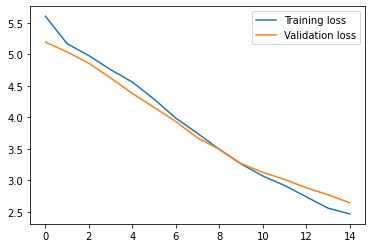

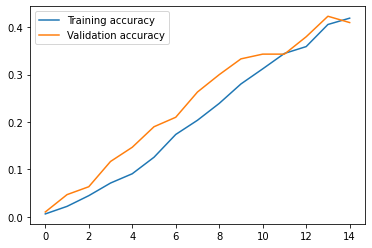

In [ ]:
# Mostrar el avance hasta ahora...
mostrarEvolucion(hist)

In [ ]:
# Descongelando los pesos desde la capa 80, si bien se supone ResNet
# tiene 50 "capas", cada una de estas están, los módulos residuales están formados 
# por otro número de capas, adicionalmente hay capas para la agreación de datos,
# etc; luego a nivel de Keras hay más de 50 capas.

# Se selecciona aquellas en las que el bloque de salida tiene un tamaño dimensional 
# de 14x14.
for layer in base.layers[80:]:
	layer.trainable = True

print("Capas de ResNet50 según Keras:")
i = 0

# Se muestran las capas entrenables y no entrenables.
for layer in base.layers:
  print("#{} Capa: {}, ¿Entrenable? {}".format(i, layer, layer.trainable))
  i += 1

Capas de ResNet50 según Keras:
#0 Capa: <keras.engine.input_layer.InputLayer object at 0x7f8a12c84850>, ¿Entrenable? False
#1 Capa: <keras.layers.convolutional.ZeroPadding2D object at 0x7f8a102d67d0>, ¿Entrenable? False
#2 Capa: <keras.layers.convolutional.Conv2D object at 0x7f8a90482c50>, ¿Entrenable? False
#3 Capa: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8a1024c6d0>, ¿Entrenable? False
#4 Capa: <keras.layers.core.activation.Activation object at 0x7f8a102700d0>, ¿Entrenable? False
#5 Capa: <keras.layers.convolutional.ZeroPadding2D object at 0x7f8a10224e10>, ¿Entrenable? False
#6 Capa: <keras.layers.pooling.MaxPooling2D object at 0x7f8a002963d0>, ¿Entrenable? False
#7 Capa: <keras.layers.convolutional.Conv2D object at 0x7f8a0025af10>, ¿Entrenable? False
#8 Capa: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8a00266950>, ¿Entrenable? False
#9 Capa: <keras.layers.core.activation.Activation object at 0x7f8a0027015

In [ ]:
# Se reinicializa el optimizador, si interesa cambiar el lr para este paso.
# opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compilando el modelo
birdNet.compile(loss = k.losses.categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
# Definidiendo constantes para el ejercicio
BATCH_SIZE = 64
EPOCHS = 15

# Entrenando el modelo
hist = trainModel(birdNet, train_it, val_it, BATCH_SIZE, EPOCHS)

Epoch 1/15
43/43 [==============================] - 37s 749ms/step - loss: 2.7200 - accuracy: 0.3437 - val_loss: 2.7597 - val_accuracy: 0.3300
Epoch 2/15
43/43 [==============================] - 31s 728ms/step - loss: 1.7274 - accuracy: 0.5507 - val_loss: 2.0037 - val_accuracy: 0.4667
Epoch 3/15
43/43 [==============================] - 31s 742ms/step - loss: 1.1905 - accuracy: 0.6937 - val_loss: 1.8205 - val_accuracy: 0.5733
Epoch 4/15
43/43 [==============================] - 31s 722ms/step - loss: 0.7898 - accuracy: 0.8007 - val_loss: 1.7810 - val_accuracy: 0.5567
Epoch 5/15
43/43 [==============================] - 31s 722ms/step - loss: 0.5860 - accuracy: 0.8541 - val_loss: 1.6424 - val_accuracy: 0.5967
Epoch 6/15
43/43 [==============================] - 31s 721ms/step - loss: 0.4300 - accuracy: 0.8907 - val_loss: 1.6276 - val_accuracy: 0.6033
Epoch 7/15
43/43 [==============================] - 31s 725ms/step - loss: 0.3123 - accuracy: 0.9307 - val_loss: 1.6223 - val_accuracy: 0.5933

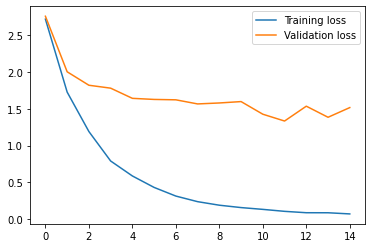

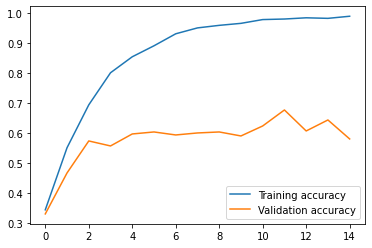

Evaluando...
95/95 [==============================] - 7s 63ms/step - loss: 2.2749 - accuracy: 0.4843
Resultados de Evaluación en Test
 - Loss: 2.274853229522705
 - Accuracy:  48.43389391899109 %


In [ ]:
# Probando el modelo con test.
testModel(birdNet, test_x, test_y, hist)